# Test trained models on other Ar41 data

In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
# Load Ar41
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Neutrons_Cut1000mm_09_04_2020", "Neutrons_Snapshots", "test")

fileprefix = "SnapshotAr41NGS*"
dfallar41 = load_dataframe_from_files(dirin, fileprefix)
print("[Info] Loaded all Ar41 in {:.2f} seconds".format(time.time() - init))

[Info] Loading 1 files wt prefix:
SnapshotAr41NGS*

[Info] Loaded all Ar41 in 0.05 seconds


In [4]:
print("[Info] Loaded {} Ar41 snapshots from NeutronsGS simulation".format(len(dfallar41)))

[Info] Loaded 10797 Ar41 snapshots from NeutronsGS simulation


# first step: cut NPE

In [7]:
print("[Info] {} events ({:.3f} %) have > 50 PE".format(len(dfallar41[(dfallar41.pedetected>50)]), 
                                                len(dfallar41[(dfallar41.pedetected>50)])/len(dfallar41)))
print("[Info] {} events ({:.3f} %) have < 5 PE".format(len(dfallar41[(dfallar41.pedetected<5)]),                                                 
                                                len(dfallar41[(dfallar41.pedetected<5)])/len(dfallar41)))

[Info] 2954 events (0.274 %) have > 50 PE
[Info] 3798 events (0.352 %) have < 5 PE


In [11]:
dfcutar41 = dfallar41[(dfallar41.pedetected>=5) & (dfallar41.pedetected<=50)]
print("[Info] Restrict focus on the remaining Ar41 wt detections in [5, 50]: {} instances ({:.3f} %)".format(len(dfcutar41), 
                                                                                                 len(dfcutar41)/len(dfallar41)))

[Info] Restrict focus on the remaining Ar41 wt detections in [5, 50]: 4045 instances (0.375 %)


# features

In [12]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

In [14]:
# Compute features muon
import time
n_inner_slices, n_outer_slices = 12, 20
init = time.time()
df_ar41_feat = pd.DataFrame()
df_ar41_feat["PEDetected_inner"] = dfcutar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar41_feat["NActiveSlices_inner"] = dfcutar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar41_feat["MeanNPEActive_inner"] = dfcutar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar41_feat["SpatialRange_inner"] = dfcutar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
df_ar41_feat["SpatialVar_inner"] = dfcutar41.iloc[:, 3:3+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar41_feat["PEDetected_outer"] = dfcutar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
df_ar41_feat["NActiveSlices_outer"] = dfcutar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df_ar41_feat["MeanNPEActive_outer"] = dfcutar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
df_ar41_feat["SpatialRange_outer"] = dfcutar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
df_ar41_feat["SpatialVar_outer"] = dfcutar41.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
print("Compute Mu Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
df_ar41_feat["PEDetected_tot"] = df_ar41_feat["PEDetected_inner"] + df_ar41_feat["PEDetected_outer"]
df_ar41_feat["NActiveSlices_tot"] = df_ar41_feat["NActiveSlices_inner"] + df_ar41_feat["NActiveSlices_outer"]
df_ar41_feat["MeanNPEActive_tot"] = df_ar41_feat["PEDetected_tot"] / df_ar41_feat["NActiveSlices_tot"]
df_ar41_feat = df_ar41_feat.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 0.341 sec
Compute Mu Outer features: 0.511 sec
Compute combined features: 0.004 sec


# load models

In [15]:
from joblib import load

dt = load("models/dt_08_09_2020.joblib")
ada = load("models/ada_08_09_2020.joblib")
rf = load("models/rf_08_09_2020.joblib")
svm = load("models/svm_08_09_2020.joblib")
logit = load("models/logit_08_09_2020.joblib")
elastic = load("models/elastic_08_09_2020.joblib")

In [16]:
# create label
df_ar41_feat["y"] = 1    # since label not used, we use it to mark the class of pileup

X, y = df_ar41_feat.iloc[:, :-1], df_ar41_feat.iloc[:, -1]
X = np.array(X)
y = np.where(y<0, 0, 1)

In [22]:
# inference
init = time.time()
df_ar41_feat["y_dt"] = dt.predict_proba(X)[:, 1]
print("[Info] Inference {} instances wt DTree: {:.3f} seconds".format(X.shape[0], time.time()-init))

init = time.time()
df_ar41_feat["y_ada"] = ada.predict_proba(X)[:, 1]
print("[Info] Inference {} instances wt AdaBoost: {:.3f} seconds".format(X.shape[0], time.time()-init))

init = time.time()
df_ar41_feat["y_rf"] = rf.predict_proba(X)[:, 1]
print("[Info] Inference {} instances wt RandomForest: {:.3f} seconds".format(X.shape[0], time.time()-init))

init = time.time()
df_ar41_feat["y_svm"] = svm.predict_proba(X)[:, 1]
print("[Info] Inference {} instances wt SVM: {:.3f} seconds".format(X.shape[0], time.time()-init))

init = time.time()
df_ar41_feat["y_logit"] = logit.predict_proba(X)[:, 1]
print("[Info] Inference {} instances wt LogisticRegression: {:.3f} seconds".format(X.shape[0], time.time()-init))

init = time.time()
df_ar41_feat["y_elastic"] = elastic.predict(X)
print("[Info] Inference {} instances wt ElasticNet: {:.3f} seconds".format(X.shape[0], time.time()-init))

[Info] Inference 4045 instances wt DTree: 0.001 seconds
[Info] Inference 4045 instances wt AdaBoost: 0.168 seconds
[Info] Inference 4045 instances wt RandomForest: 0.015 seconds
[Info] Inference 4045 instances wt SVM: 0.664 seconds
[Info] Inference 4045 instances wt LogisticRegression: 0.001 seconds
[Info] Inference 4045 instances wt ElasticNet: 0.001 seconds


In [23]:
dt_eff = len(df_ar41_feat[(df_ar41_feat.y==1) & (df_ar41_feat.y_dt>.50)])/len(df_ar41_feat[(df_ar41_feat.y==1)])
ada_eff = len(df_ar41_feat[(df_ar41_feat.y==1) & (df_ar41_feat.y_ada>.50)])/len(df_ar41_feat[(df_ar41_feat.y==1)])
rf_eff = len(df_ar41_feat[(df_ar41_feat.y==1) & (df_ar41_feat.y_rf>.50)])/len(df_ar41_feat[(df_ar41_feat.y==1)])

print("[Info] Efficiency DTree: {:.5f}".format(dt_eff))
print("[Info] Efficiency AdaBoost: {:.5f}".format(ada_eff))
print("[Info] Efficiency RandomForest: {:.5f}".format(rf_eff))

svm_eff = len(df_ar41_feat[(df_ar41_feat.y==1) & (df_ar41_feat.y_svm>.50)])/len(df_ar41_feat[(df_ar41_feat.y==1)])
logit_eff = len(df_ar41_feat[(df_ar41_feat.y==1) & (df_ar41_feat.y_logit>.50)])/len(df_ar41_feat[(df_ar41_feat.y==1)])
elastic_eff = len(df_ar41_feat[(df_ar41_feat.y==1) & (df_ar41_feat.y_elastic>.50)])/len(df_ar41_feat[(df_ar41_feat.y==1)])

print("[Info] Efficiency SVM: {:.5f}".format(svm_eff))
print("[Info] Efficiency LogisticRegression: {:.5f}".format(logit_eff))
print("[Info] Efficiency ElasticNet: {:.5f}".format(elastic_eff))

[Info] Efficiency DTree: 0.74438
[Info] Efficiency AdaBoost: 0.77429
[Info] Efficiency RandomForest: 0.82002
[Info] Efficiency SVM: 0.77651
[Info] Efficiency LogisticRegression: 0.74561
[Info] Efficiency ElasticNet: 0.53449


In [3]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 44})

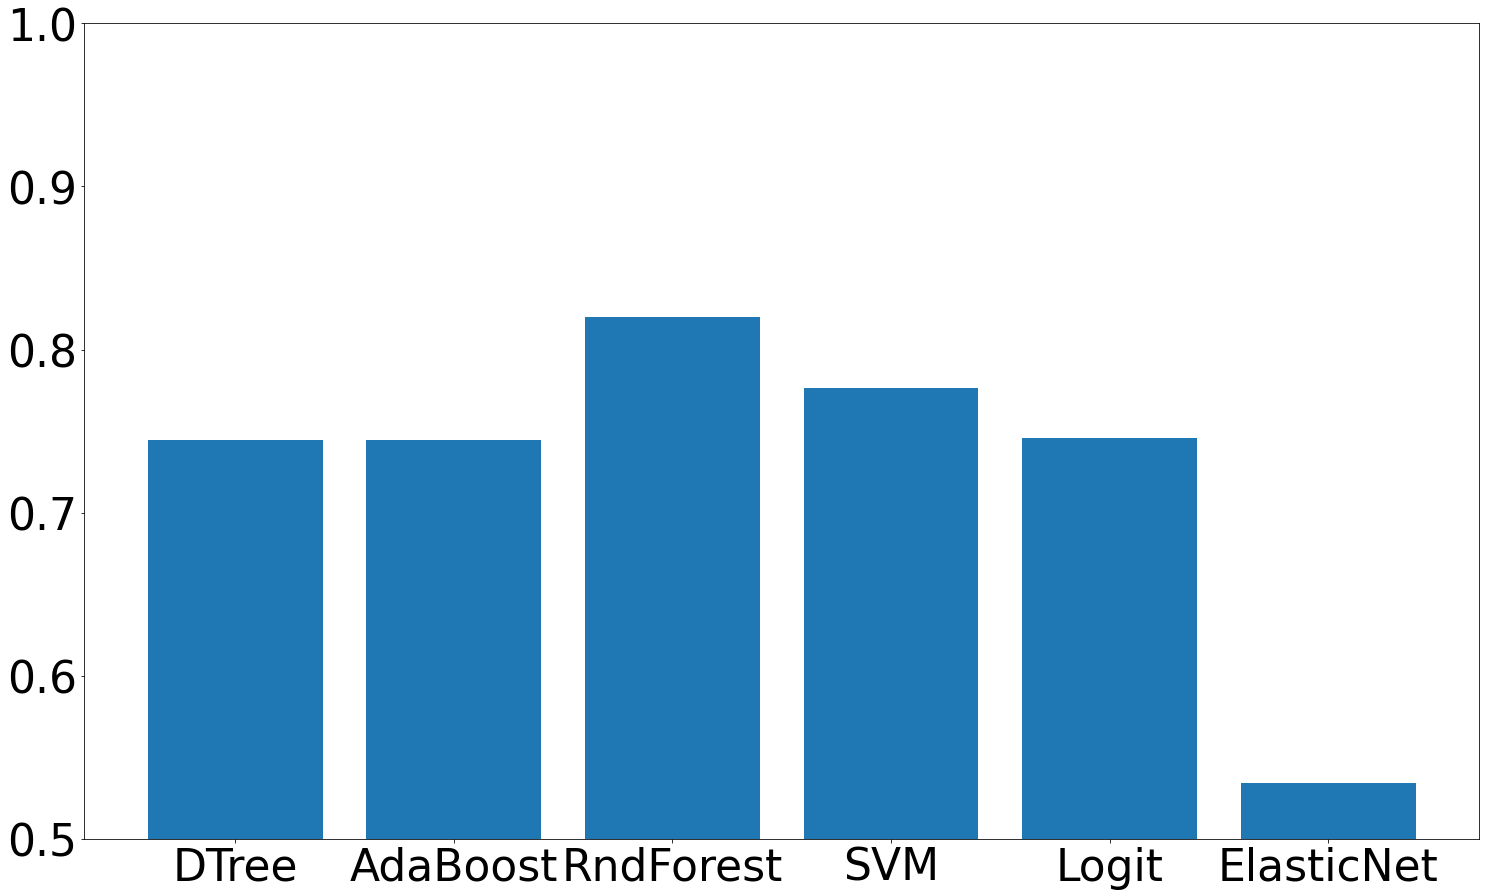

In [5]:
tprs = [.74438, .74429, .82002, .77651, .74561, .53449]
names = ["DTree", "AdaBoost", "RndForest", "SVM", "Logit", "ElasticNet"]

plt.bar(range(6), tprs)
plt.xticks(range(6), names)
plt.ylim(.5, 1)
plt.show()